# Hyperparameter optimization and results visualization

This file contains code snippets for hyperparameter optimization and visualization of results using the `reservoirpy` library. The code demonstrates how to plot hyperparameter optimization reports and manage configuration files for experiments.

In [1]:
import csv 
import os 
import math 
import numpy as np
from datetime import datetime


from data_loading import load_X_Y, plot_results
from normalization import normalize_data, denormalize_data

dpath = '../dataset/preprocessed/'
file_name = 'A146020302.csv'

data = load_X_Y(dpath + file_name)

In [2]:
from reservoirpy.datasets import to_forecasting

data, min_vals, max_vals = normalize_data(data)
x,y= to_forecasting(data[3156:], forecast=7)
print(x.shape, y.shape)
print(y)
y = y[:, -1].reshape(-1, 1) # chosing the data that will be used (electricity consuption)
# units = 200 
# alpha = 0.009838765758022786
# leak_rate = 0.6079924819654108
# spectral_radius = 0.8838547867045398
# input_scaling = 1.0
# connectivity = 0.001983076302206145
# input_connectivity = 0.061394244538574685
# regularization = 1e-1
# seed = 42
# X_train1, y_train1 = x[:1500], y[:1500]
# X_test1, y_test1 = x[1500:], y[1500:]
# X_test1 = np.asarray(X_test1) # chosing the data that will be used (electricity consuption)
# X_test1 = X_test1.reshape(X_test1.shape[0], -1) # reshaping data that they could be used by reservoir py
# plot_train_test(X_train1, y_train1, X_test1, y_test1)


(7494, 3) (7494, 3)
[[0.00189458 0.54348387 0.36541353]
 [0.00271635 0.55204571 0.36691729]
 [0.00368529 0.56059216 0.36541353]
 ...
 [0.28084846 0.05057739 0.21804511]
 [0.27315022 0.05441371 0.21503759]
 [0.26551911 0.05838188 0.21203008]]


In [3]:

# pred_data = denormalize_data(pred_online, min_vals[-1], max_vals[-1])
# y_test_data = denormalize_data(y_test1, min_vals[-1], max_vals[-1])
# print(np.mean(y_test_data - pred_data))
# print(np.max(y_test_data - pred_data))

# _from = 100
# _to = 200
# step = _to - _from

# print(pred_data.shape, y_test_data.shape)

# # plot_results(pred_online[_from:],y_test1[_from:], sample=_to - _from)
# for i in range(5):
#     plot_results(pred_data[_from+i*step :],y_test_data[_from+i*step:], sample=step) 

In [4]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result of the loss function.
# You can add any additional metrics or information with other keys in the dict. See hyperopt documentation for more informations.
from reservoirpy.observables import nrmse, rsquare

In [5]:
train_len = 1000
forecast = 7

X_train = x[:train_len]
Y_train = x[forecast : train_len + forecast]

X_test = x[train_len : -forecast]
Y_test = x[train_len + forecast:]

dataset = (X_train, X_test, Y_train, Y_test)

## Configuration de la recherche d'hyperparamètre

Un fichier de config est généré sur la base de l'objet ci-dessous. Plus les paramètres à explorer sont nombreux, plus la recherche prendra du temps.

**Attention** : les paramètres dans `hp_space` doivent correspondre aux arguments de la fonction `objective`.


Point d'attention aussi pour l'input_scaling, plusieurs entrées sont utilisées, il faut donc définir un scaling pour chaque entrée. Dans cet exemple, on utilise 6 entrées (1,2,3,4,5 et la 24).





In [6]:
import json
hyperopt_directory = "hyperopt/"
exp_directory = "exps/"
exp_config_directory = "configs/"

exp_name = "hyperopt-input-scaling-multi"
# Calculate the version number based on existing files in the directory
existing_versions = []
if os.path.exists(hyperopt_directory + exp_directory):
    for folder_name in os.listdir(hyperopt_directory + exp_directory):
        if folder_name.startswith(exp_name):
            try:
                version = int(folder_name.split('-')[-1])
                existing_versions.append(version)
            except (ValueError, IndexError):
                pass

exp_version = max(existing_versions) + 1 if existing_versions else 1

hyperopt_config = {
    "exp": exp_name + "-" + str(exp_version),    # the experimentation name
    "hp_max_evals": 200,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 150],             # the number of neurons is fixed to 500
        "sr": ["choice", 0.8838547867045398],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["choice", 0.4981590552238297],    # idem with the leaking rate, from 1e-3 to 1
        # "input_scaling": ["loguniform", [5e-1, 5e-1, 5e-1],[ 1,1,1]], # the input scaling is fixed
        "alpha": ["choice", 0.009838765758022786],        # and so is the regularization parameter.
        "input_connectivity": ["choice", 0.061394244538574685], # exploring input connectivity
        # "connectivity": ["loguniform", 1e-3, 1], # exploring reservoir connectivity
        "seed": ["choice", 1234],          # an other random seed for the ESN initialization
        "input_scaling_1":  ["loguniform", 1e-5, 1e0], 
        "input_scaling_2":  ["loguniform", 1e-5, 1e0], 
        "input_scaling_3":  ["loguniform", 1e-5, 1e0], 
        "input_scaling_4":  ["loguniform", 1e-5, 1e0], 
        "input_scaling_5":  ["loguniform", 1e-5, 1e0],
        "input_scaling_24":  ["choice", 0.7904117777131483],
    }
}

config_file_name = f"{hyperopt_directory}{exp_config_directory}{hyperopt_config['exp']}.config.json"
results_directory = hyperopt_directory + exp_directory 

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(config_file_name, "w+") as f:
    json.dump(hyperopt_config, f)

# mkdir results_diretory 
os.makedirs(results_directory, exist_ok=True)

In [7]:
from reservoirpy.mat_gen import bernoulli
from reservoirpy.nodes import RLS
from reservoirpy.nodes import Reservoir 

def objective(dataset, config, *, N, sr, lr, alpha, input_connectivity, seed, input_scaling_1, input_scaling_2, input_scaling_3, input_scaling_4, input_scaling_5, input_scaling_24):
    # This step may vary depending on what you put inside 'dataset'
    x_train, x_test, y_train, y_test = dataset
    
    # You can access anything you put in the config file from the 'config' parameter.
    instances = config["instances_per_trial"]
    

    Win_default = bernoulli(N, x_train.shape[1], connectivity=input_connectivity )
    Input_Scaling = [input_scaling_1, input_scaling_2, input_scaling_24]

    # The seed should be changed across the instances to be sure there is no bias in the results due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(
            units=N, 
            sr=sr, 
            lr=lr, 
            seed=variable_seed,
            input_connectivity=input_connectivity,
            # rc_connectivity=connectivity,
            Win=Win_default * Input_Scaling
        )

        readout = RLS(alpha=alpha)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(x_train, y_train) \
                           .run(x_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [8]:
from reservoirpy.hyper import parallel_research
best = parallel_research(objective, dataset, config_file_name, results_directory)

hyperopt/exps/hyperopt-input-scaling-multi-7/results


100%|██████████| 200/200 [02:02<00:00,  1.63trial/s, best loss=0.0265]


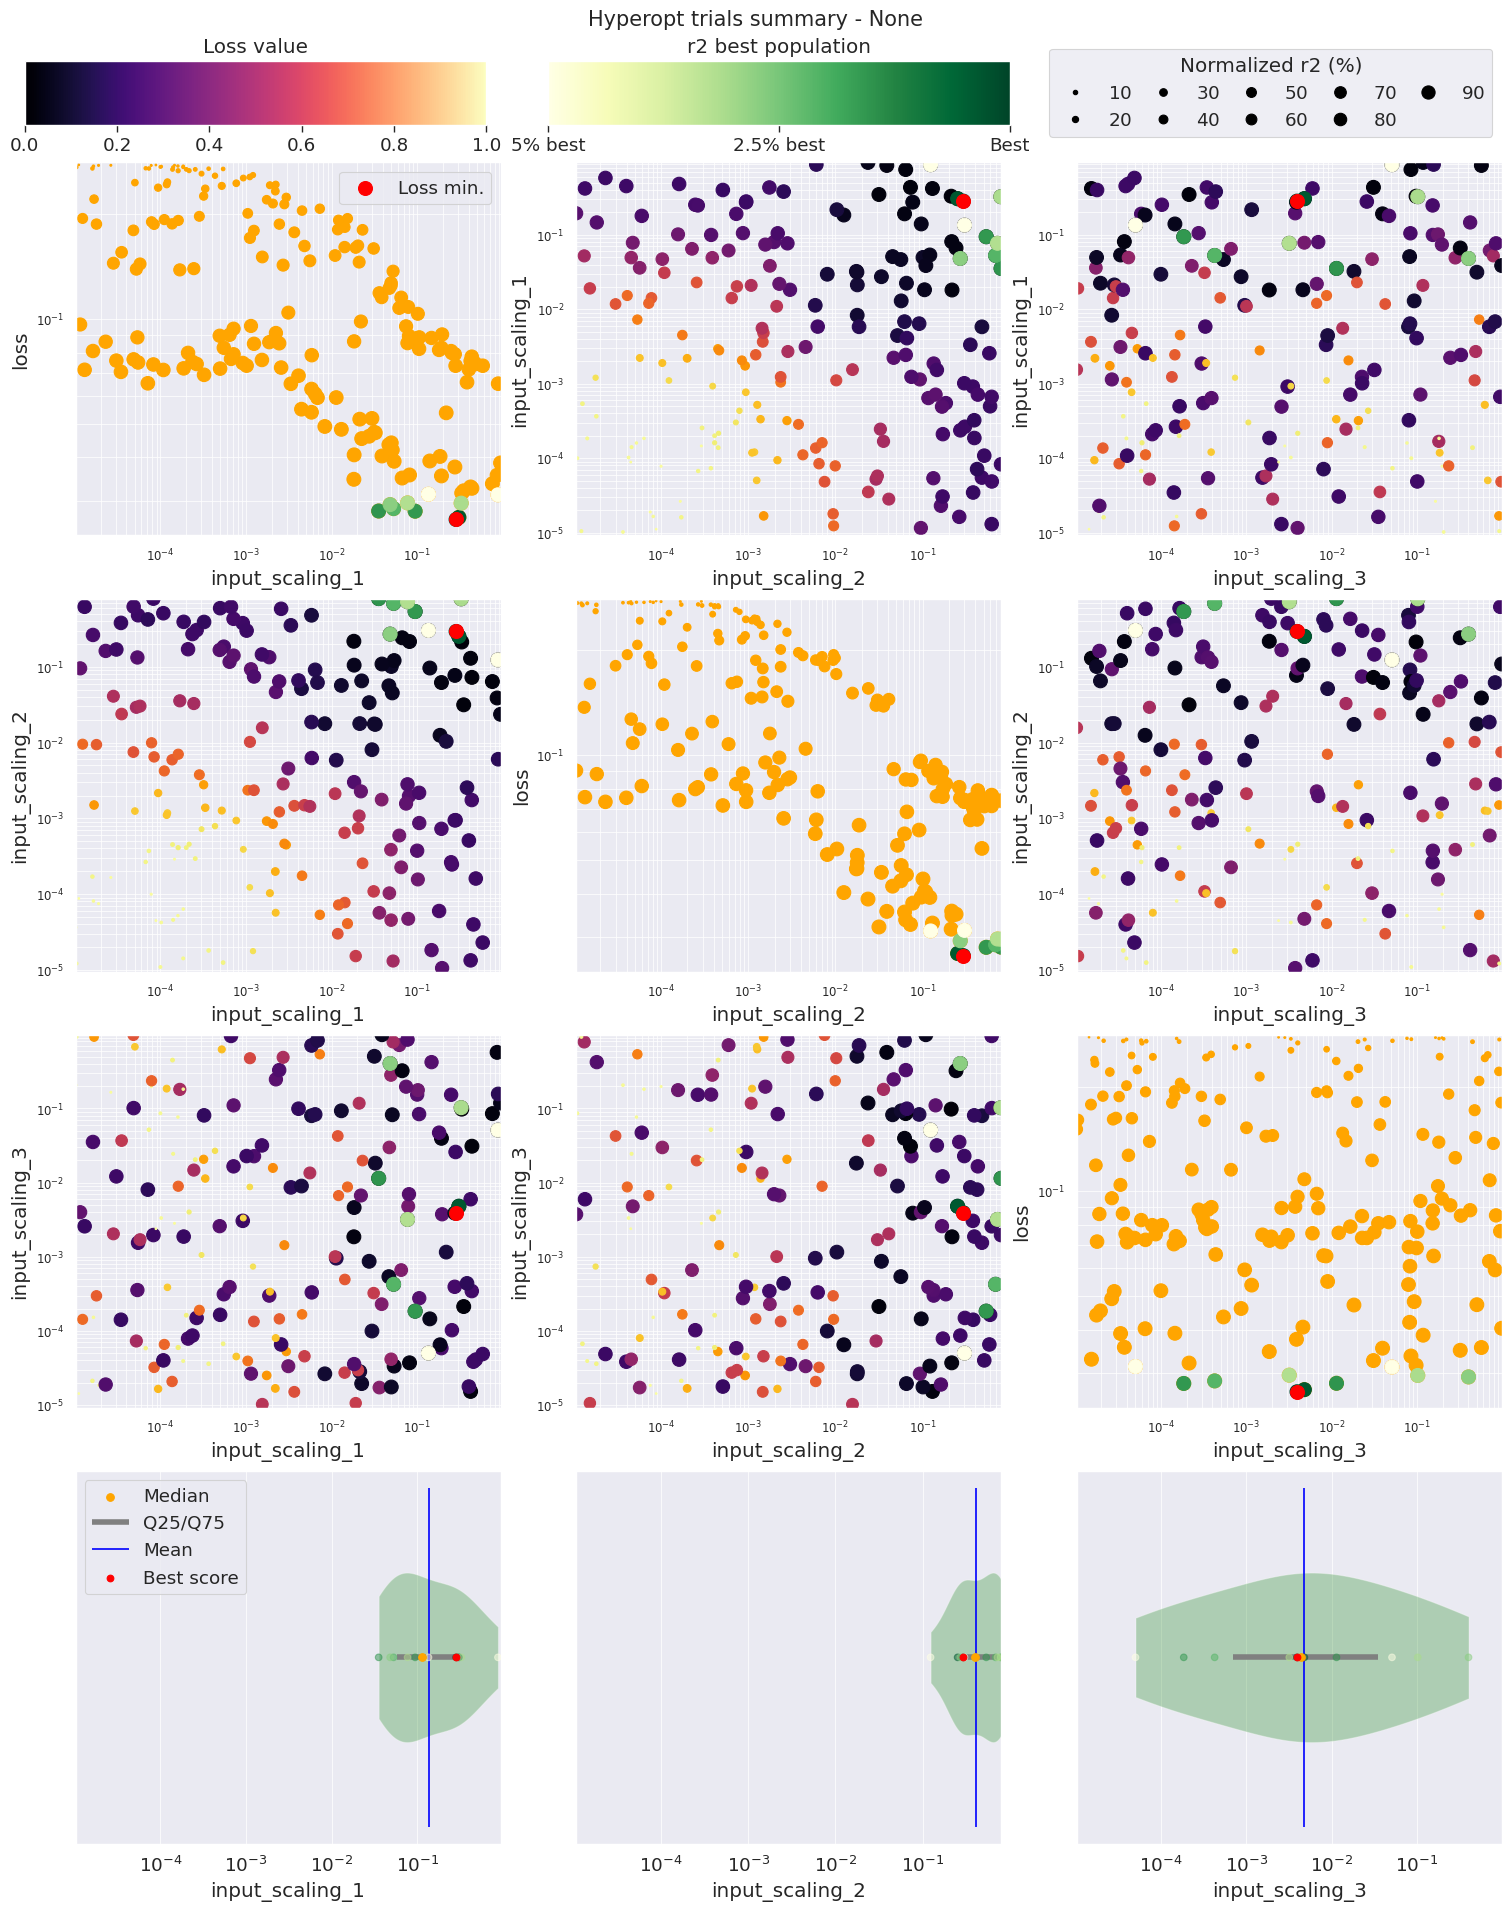

In [9]:
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(results_directory+hyperopt_config['exp'], ("input_scaling_1", "input_scaling_2", "input_scaling_3"), metric="r2")